# E4: Nonzero-start H-PID via shift propagators

This notebook validates the **corrected** nonzero initial condition approach
(Appendix C.1–C.2) for the 1D DR bimodal→bimodal problem.

**Part A** — Deterministic start $x_0 = z \neq 0$:
1. *Coordinate-shift* (gold standard): rebuild field with $\tilde\nu = \nu - z$,
   $\tilde m_k = m_k - z$; simulate from 0; add $z$ back.
2. *Propagator approach*: use `ShiftedField` with precomputed $\lambda$ propagators.

Both must match $p^{(\mathrm{tar})}$ at $t=1$.

**Part B** — Random start $x_0 \sim p^{(\mathrm{in})}$ (2-mode GMM):
use `ShiftedField` with per-particle $z$.

In [1]:
# Imports
import sys
from pathlib import Path
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

HERE = Path().resolve()
ROOT = HERE.parents[1] if HERE.name == "test" else HERE.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from guided_continuous import (
    PWCProtocol, ContinuousCoeffs, GaussianMixture, GuidedField,
    TimeDomain, euler_maruyama_guided,
)
from guided_continuous.shift_propagators import ShiftPropagators
from guided_continuous.shifted_field import ShiftedField
from guided_continuous.sde import (
    _build_break_aligned_grid, _make_break_set, _time_eval_right_limit,
)
from guided_continuous.guided_field import _as_batch_time

device = torch.device("cpu")
dtype  = torch.float64
torch.set_default_dtype(dtype)
print("ROOT:", ROOT, "  device:", device, "  dtype:", dtype)

ROOT: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks   device: cpu   dtype: torch.float64


## Problem specification (DR toy model, same as E3)

In [2]:
# Distributions
pi = torch.tensor([0.60, 0.40], dtype=dtype, device=device)

# Initial (post-curtailment): warmer
m_in  = torch.tensor([[1.0], [3.0]], dtype=dtype, device=device)
s_in  = torch.tensor([0.30, 0.40], dtype=dtype, device=device)

# Target (post-recovery): cooler
m_tar = torch.tensor([[0.0], [2.0]], dtype=dtype, device=device)
s_tar = torch.tensor([0.25, 0.35], dtype=dtype, device=device)

def cov_from_std(s):
    return (s**2).reshape(-1, 1, 1)

gm_in  = GaussianMixture(weights=pi, means=m_in,  covs=cov_from_std(s_in))
gm_tar = GaussianMixture(weights=pi, means=m_tar, covs=cov_from_std(s_tar))

print("gm_in :", gm_in.weights.tolist(), gm_in.means.flatten().tolist())
print("gm_tar:", gm_tar.weights.tolist(), gm_tar.means.flatten().tolist())

gm_in : [0.6, 0.4] [1.0, 3.0]
gm_tar: [0.6, 0.4] [0.0, 2.0]


## PWC protocol (same as E3)

In [3]:
# Protocol
time_domain = TimeDomain(eps=1e-3)

breaks = torch.tensor([0.0, 0.25, 0.50, 0.75, 1.0], dtype=dtype, device=device)
beta_vals = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=dtype, device=device)
nu_vals = torch.zeros((4, 1), dtype=dtype, device=device)

beta = PWCProtocol(breaks=breaks, values=beta_vals, time_domain=time_domain)
nu   = PWCProtocol(breaks=breaks, values=nu_vals,   time_domain=time_domain)

coeffs = ContinuousCoeffs(beta=beta, nu=nu, time_domain=time_domain)
field  = GuidedField(coeffs=coeffs, target=gm_tar, time_domain=time_domain)

print("breaks:", breaks.tolist())
print("a_plus_1:", float(coeffs.a_plus_1))

breaks: [0.0, 0.25, 0.5, 0.75, 1.0]
a_plus_1: 1.3130352854993315


## Build shift propagators

In [4]:
# Propagators
prop = ShiftPropagators(coeffs)
print(f"λ⁺(1) = {float(prop.lambda_plus_1):.6f}")

# Spot-check: evaluate at a few times
t_test = torch.tensor([0.1, 0.25, 0.5, 0.75, 0.9], dtype=dtype)
print("λ⁺(t)  :", prop.lambda_plus(t_test).tolist())
print("λ⁻ₓ(t) :", prop.lambda_x_minus(t_test).tolist())
print("λ⁻ᵧ(t) :", prop.lambda_y_minus(t_test).tolist())

λ⁺(1) = 0.462117
λ⁺(t)  : [0.049958374957879026, 0.12435300177159626, 0.24491866240370896, 0.35835739835078606, 0.4218990052500078]
λ⁻ₓ(t) : [-0.42189900525000323, -0.35835739835078306, -0.244918662403708, -0.12435300177159621, -0.04995837495787996]
λ⁻ᵧ(t) : [-0.4218990052499963, -0.35835739835077807, -0.2449186624037061, -0.12435300177159621, -0.04995837495787996]


## Helpers

In [5]:
# Helpers
def sample_gmm_1d(gm, B, *, seed=0):
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))
    comp = torch.multinomial(gm.weights, B, replacement=True, generator=gen)
    means = gm.means[comp, 0]
    vars_ = gm.covs[comp, 0, 0]
    x = means + torch.sqrt(vars_) * torch.randn(B, dtype=dtype, device=device, generator=gen)
    return x.reshape(B, 1), comp

def gmm_pdf_1d(x, gm):
    w = gm.weights.detach().cpu().numpy()
    m = gm.means.detach().cpu().numpy().reshape(-1)
    v = gm.covs.detach().cpu().numpy().reshape(-1)
    out = np.zeros_like(x, dtype=float)
    for k in range(len(w)):
        out += w[k] * (1/np.sqrt(2*np.pi*v[k])) * np.exp(-0.5*(x - m[k])**2 / v[k])
    return out

FIG_DIR = Path("figs/e4_shifted")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def simulate_shifted_field(
    sf,   # ShiftedField
    z,    # (B,d) or scalar
    *,
    B=10000, n_steps=4000, seed=0,
    snap_times=(0.25, 0.50, 0.75, 0.999),
):
    """EM simulation in shifted coords x̃₀=0, then translate back by z."""
    if isinstance(z, (int, float)):
        z_batch = torch.full((B, 1), z, dtype=dtype, device=device)
    else:
        z_batch = z.to(dtype=dtype, device=device)
        if z_batch.ndim == 1:
            z_batch = z_batch.unsqueeze(-1)
        B = z_batch.shape[0]

    x = torch.zeros((B, 1), dtype=dtype, device=device)  # x̃₀ = 0

    times = _build_break_aligned_grid(
        n_steps=n_steps, breaks=sf.coeffs.breaks,
        dtype=dtype, device=device, time_domain=sf.time_domain,
    )
    bset = _make_break_set(sf.coeffs.breaks, dtype=dtype, device=device,
                           time_domain=sf.time_domain)
    dt_vec = times[1:] - times[:-1]

    snap_idx = {}
    for st in snap_times:
        st_c = float(sf.time_domain.clamp(torch.tensor(st, dtype=dtype)).item())
        idx = int(torch.argmin(torch.abs(times - st_c)).item())
        snap_idx[idx] = st

    snaps = {}
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))

    for i in range(times.numel() - 1):
        t = times[i]
        dt = dt_vec[i]
        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device, post_jump_eps=1e-12)
        drift = sf.u_star(t_eval, x, z_batch)
        noise = torch.randn((B, 1), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + torch.sqrt(dt) * noise

        if i in snap_idx:
            snaps[float(times[i].item())] = (x + z_batch).detach().cpu().numpy().reshape(-1)

    snaps[float(times[-1].item())] = (x + z_batch).detach().cpu().numpy().reshape(-1)
    return times.detach().cpu().numpy(), snaps


def simulate_standard_field(
    field,  # GuidedField (rebuilt with shifted protocol/target)
    z_val,  # scalar
    *,
    B=10000, n_steps=4000, seed=0,
    snap_times=(0.25, 0.50, 0.75, 0.999),
):
    """Gold-standard: standard field with shifted protocol, x̃₀=0, translate back."""
    x = torch.zeros((B, 1), dtype=dtype, device=device)

    times = _build_break_aligned_grid(
        n_steps=n_steps, breaks=field.coeffs.breaks,
        dtype=dtype, device=device, time_domain=field.time_domain,
    )
    bset = _make_break_set(field.coeffs.breaks, dtype=dtype, device=device,
                           time_domain=field.time_domain)
    dt_vec = times[1:] - times[:-1]

    snap_idx = {}
    for st in snap_times:
        st_c = float(field.time_domain.clamp(torch.tensor(st, dtype=dtype)).item())
        idx = int(torch.argmin(torch.abs(times - st_c)).item())
        snap_idx[idx] = st

    snaps = {}
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))

    for i in range(times.numel() - 1):
        t = times[i]
        dt = dt_vec[i]
        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device, post_jump_eps=1e-12)
        drift = field.u_star(t_eval, x)       # standard z=0 API
        noise = torch.randn((B, 1), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + torch.sqrt(dt) * noise

        if i in snap_idx:
            snaps[float(times[i].item())] = (x + z_val).detach().cpu().numpy().reshape(-1)

    snaps[float(times[-1].item())] = (x + z_val).detach().cpu().numpy().reshape(-1)
    return times.detach().cpu().numpy(), snaps


def terminal_validation(snaps, gm_tar, *, label="", xrange=(-2.5, 4.5)):
    """Histogram + overlay + responsibilities for the terminal snapshot."""
    xgrid = np.linspace(*xrange, 800)
    ptar = gmm_pdf_1d(xgrid, gm_tar)
    xT = snaps[sorted(snaps.keys())[-1]]

    hist, edges = np.histogram(xT, bins=140, range=xrange, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])

    fig, ax = plt.subplots()
    ax.plot(xgrid, ptar, 'k-', lw=2, label=r"$p^{(\mathrm{tar})}$")
    ax.plot(centers, hist, label="empirical $p_1$")
    ax.set_xlabel("$x$"); ax.set_ylabel("density")
    ax.set_title(f"Terminal fit — {label}")
    ax.legend()
    fig.tight_layout()

    # responsibilities
    w = gm_tar.weights.detach().cpu().numpy()
    m = gm_tar.means.detach().cpu().numpy().reshape(-1)
    v = gm_tar.covs.detach().cpu().numpy().reshape(-1)
    r = np.stack([w[k]*(1/np.sqrt(2*np.pi*v[k]))*np.exp(-0.5*(xT-m[k])**2/v[k])
                  for k in range(len(w))], axis=1)
    r = r / (r.sum(axis=1, keepdims=True) + 1e-300)
    avg_R = r.mean(axis=0)

    print(f"[{label}]  target weights: {w}")
    print(f"[{label}]  empirical resp: {avg_R}")
    print(f"[{label}]  diff:           {avg_R - w}")
    return fig

---
# Part A: Deterministic start $x_0 = z \neq 0$

We pick $z = 1.5$ (between the two target modes).
Both methods must recover $p^{(\mathrm{tar})}$ at $t=1$.

### A1: Gold standard — coordinate-shift approach (validated z=0 API)

In [6]:
# A1: build shifted field
z_val = 1.5
z_vec = torch.tensor([[z_val]], dtype=dtype, device=device)

# shifted target: m̃_k = m_k − z
gm_tar_shifted = GaussianMixture(
    weights=gm_tar.weights.clone(),
    means=gm_tar.means - z_vec,
    covs=gm_tar.covs.clone(),
)
# shifted guidance: ν̃ = ν − z
nu_shifted_vals = nu_vals - z_vec.expand_as(nu_vals)
nu_shifted = PWCProtocol(breaks=breaks, values=nu_shifted_vals, time_domain=time_domain)
coeffs_shifted = ContinuousCoeffs(beta=beta, nu=nu_shifted, time_domain=time_domain)
field_shifted  = GuidedField(coeffs=coeffs_shifted, target=gm_tar_shifted, time_domain=time_domain)

print(f"z = {z_val}")
print(f"shifted ν₀ = {nu_shifted_vals[0].item():.2f}")
print(f"shifted target means: {gm_tar_shifted.means.flatten().tolist()}")

z = 1.5
shifted ν₀ = -1.50
shifted target means: [-1.5, 0.5]


[A1: coord-shift]  target weights: [0.6 0.4]
[A1: coord-shift]  empirical resp: [0.597397 0.402603]
[A1: coord-shift]  diff:           [-0.002603  0.002603]


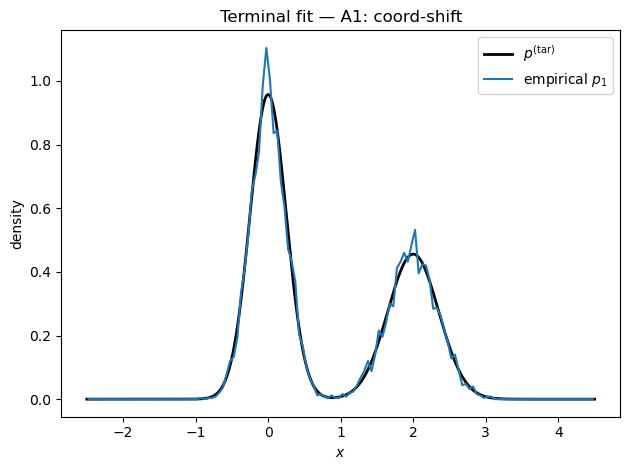

In [7]:
# A1: simulate
B = 5000
_, snaps_A1 = simulate_standard_field(field_shifted, z_val, B=B, n_steps=1000, seed=7)

fig_A1 = terminal_validation(snaps_A1, gm_tar, label="A1: coord-shift")
fig_A1.savefig(FIG_DIR / "e4_A1_terminal.pdf"); plt.show()

### A2: Propagator approach — `ShiftedField`

In [8]:
# A2: build ShiftedField from base field + propagators
sf = ShiftedField(field, prop)

# Quick sanity: evaluate score at a single point
x_test = torch.tensor([[0.5]], dtype=dtype)
z_test = torch.tensor([[z_val]], dtype=dtype)
print("u*(0.5, x̃=0.5; z=1.5) =", sf.u_star(torch.tensor(0.5), x_test, z_test).item())

u*(0.5, x̃=0.5; z=1.5) = -0.5128977136759871


[A2: propagator]  target weights: [0.6 0.4]
[A2: propagator]  empirical resp: [0.59740056 0.40259944]
[A2: propagator]  diff:           [-0.00259944  0.00259944]


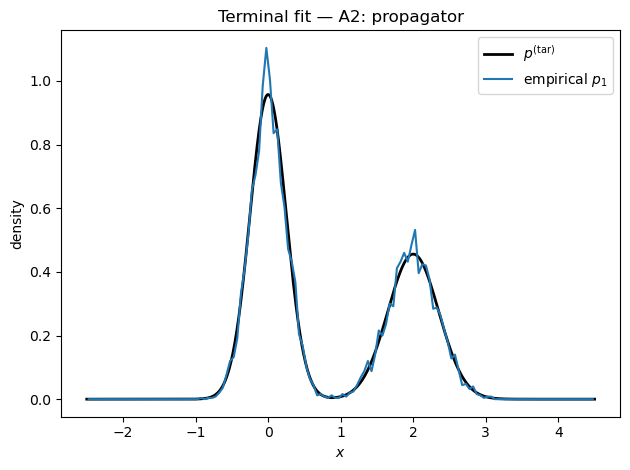

In [10]:
# A2: simulate (same seed & n_steps for fair comparison)
_, snaps_A2 = simulate_shifted_field(sf, z_val, B=B, n_steps=1000, seed=7)

fig_A2 = terminal_validation(snaps_A2, gm_tar, label="A2: propagator")
fig_A2.savefig(FIG_DIR / "e4_A2_terminal.pdf"); plt.show()

### A1 vs A2: overlay comparison

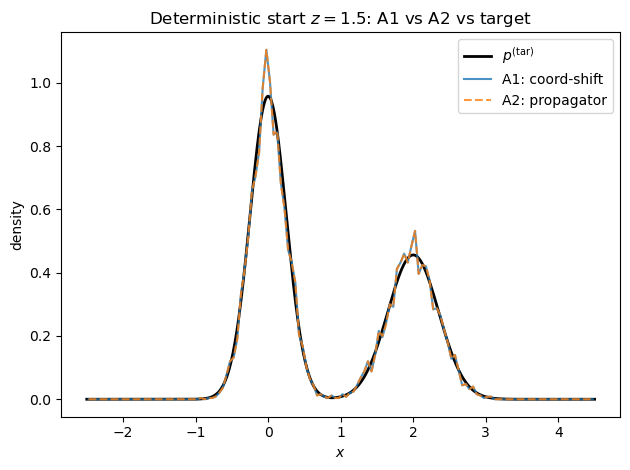

In [11]:
# A1 vs A2 overlay
xgrid = np.linspace(-2.5, 4.5, 800)
ptar = gmm_pdf_1d(xgrid, gm_tar)

xT_A1 = snaps_A1[sorted(snaps_A1.keys())[-1]]
xT_A2 = snaps_A2[sorted(snaps_A2.keys())[-1]]

h1, e1 = np.histogram(xT_A1, bins=140, range=(-2.5, 4.5), density=True)
h2, e2 = np.histogram(xT_A2, bins=140, range=(-2.5, 4.5), density=True)
c1 = 0.5*(e1[:-1]+e1[1:])
c2 = 0.5*(e2[:-1]+e2[1:])

fig, ax = plt.subplots()
ax.plot(xgrid, ptar, 'k-', lw=2, label=r"$p^{(\mathrm{tar})}$")
ax.plot(c1, h1, label="A1: coord-shift", alpha=0.8)
ax.plot(c2, h2, '--', label="A2: propagator", alpha=0.8)
ax.set_xlabel("$x$"); ax.set_ylabel("density")
ax.set_title(f"Deterministic start $z={z_val}$: A1 vs A2 vs target")
ax.legend()
fig.tight_layout()
fig.savefig(FIG_DIR / "e4_A1_vs_A2.pdf"); plt.show()

### Propagator cross-validation: compare λ against explicit rebuild

For ν≡0, the base θ coefficients are all zero.  The shifted θ coefficients
(with ν→ −z) should satisfy:
- $\tilde\theta^+_t = 0 - \lambda^+(t)\,z$
- $\tilde\theta^-_{x,t} = 0 + \lambda^-_x(t)\,z$
- $\tilde\theta^-_{y,t} = 0 + \lambda^-_y(t)\,z$

We compare these against the explicitly rebuilt coefficients.

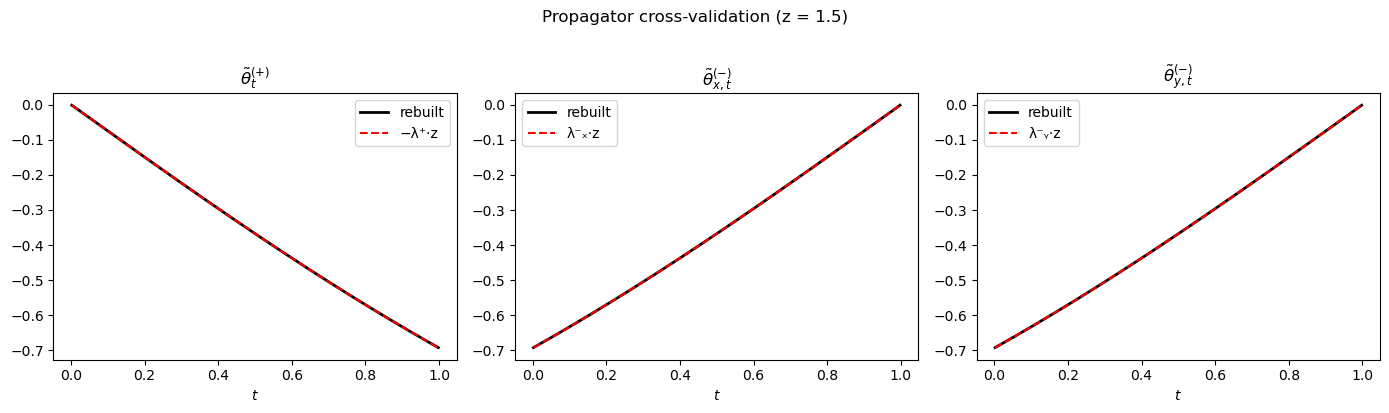

Max abs errors — θ⁺: 2.22e-16,  θ⁻ₓ: 3.75e-04,  θ⁻ᵧ: 3.75e-04


In [12]:
# Cross-validation
t_grid = torch.linspace(0.002, 0.998, 200, dtype=dtype)

# Propagator predictions
lp  = prop.lambda_plus(t_grid).detach().numpy()
lxm = prop.lambda_x_minus(t_grid).detach().numpy()
lym = prop.lambda_y_minus(t_grid).detach().numpy()

# Explicit shifted coefficients (from rebuilt ContinuousCoeffs with ν = −z)
thp_rebuilt  = coeffs_shifted.theta_plus(t_grid).detach().numpy().reshape(-1)
thxm_rebuilt = coeffs_shifted.theta_x_minus(t_grid).detach().numpy().reshape(-1)
thym_rebuilt = coeffs_shifted.theta_y_minus(t_grid).detach().numpy().reshape(-1)

# Predictions from propagators: θ̃ = base_θ − λ·z (for +), θ̃ = base_θ + λ·z (for −)
# With ν≡0, base θ ≡ 0, so:
pred_thp  = -lp * z_val
pred_thxm =  lxm * z_val
pred_thym =  lym * z_val

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
tn = t_grid.numpy()

axes[0].plot(tn, thp_rebuilt, 'k-', lw=2, label="rebuilt")
axes[0].plot(tn, pred_thp, 'r--', lw=1.5, label="−λ⁺·z")
axes[0].set_title(r"$\tilde\theta^{(+)}_t$")
axes[0].legend()

axes[1].plot(tn, thxm_rebuilt, 'k-', lw=2, label="rebuilt")
axes[1].plot(tn, pred_thxm, 'r--', lw=1.5, label="λ⁻ₓ·z")
axes[1].set_title(r"$\tilde\theta^{(-)}_{x,t}$")
axes[1].legend()

axes[2].plot(tn, thym_rebuilt, 'k-', lw=2, label="rebuilt")
axes[2].plot(tn, pred_thym, 'r--', lw=1.5, label="λ⁻ᵧ·z")
axes[2].set_title(r"$\tilde\theta^{(-)}_{y,t}$")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("$t$")
fig.suptitle(f"Propagator cross-validation (z = {z_val})", y=1.02)
fig.tight_layout()
fig.savefig(FIG_DIR / "e4_propagator_xval.pdf"); plt.show()

err_p  = np.max(np.abs(thp_rebuilt  - pred_thp))
err_xm = np.max(np.abs(thxm_rebuilt - pred_thxm))
err_ym = np.max(np.abs(thym_rebuilt - pred_thym))
print(f"Max abs errors — θ⁺: {err_p:.2e},  θ⁻ₓ: {err_xm:.2e},  θ⁻ᵧ: {err_ym:.2e}")

---
# Part B: Random start $x_0 \sim p^{(\mathrm{in})}$ (2-mode GMM)

Each particle samples its own $z^{(i)} \sim p^{(\mathrm{in})}$ and uses the
`ShiftedField` with per-particle $z$.  The validated $x_0=0$ dynamics run in
shifted coordinates $\tilde x = x - z$; physical trajectories are
$X_t = \tilde x_t + z$.

### B: simulation with per-particle z

In [13]:
# B: sample initial conditions and simulate
B_partB = 1000

z0, labels = sample_gmm_1d(gm_in, B_partB, seed=42)
print(f"Sampled {B_partB} initial conditions from p_in")
print(f"  component 0 fraction: {(labels==0).float().mean().item():.3f}")
print(f"  component 1 fraction: {(labels==1).float().mean().item():.3f}")

_, snaps_B = simulate_shifted_field(
    sf, z0, B=B_partB, n_steps=1000, seed=7,
    snap_times=(0.1, 0.25, 0.5, 0.75),
)

Sampled 1000 initial conditions from p_in
  component 0 fraction: 0.623
  component 1 fraction: 0.377


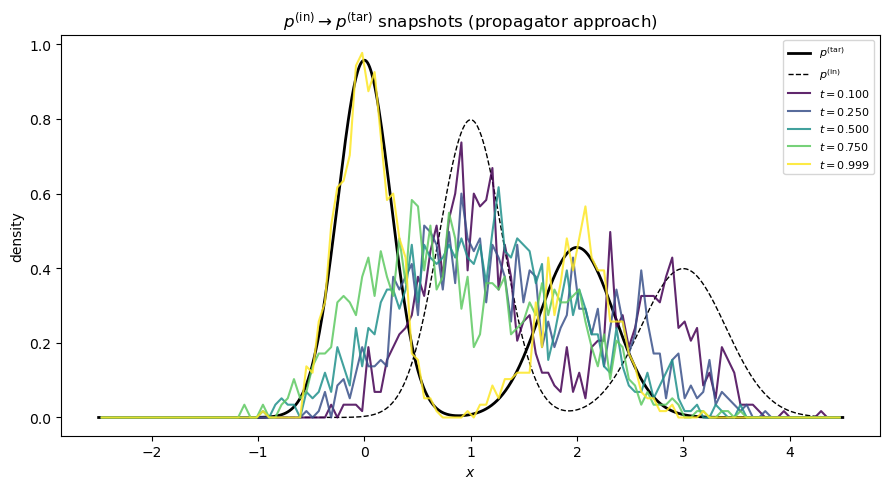

In [17]:
# B: snapshot evolution
xgrid = np.linspace(-2.5, 4.5, 800)
ptar = gmm_pdf_1d(xgrid, gm_tar)
pin  = gmm_pdf_1d(xgrid, gm_in)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(xgrid, ptar, 'k-', lw=2, label=r"$p^{(\mathrm{tar})}$")
ax.plot(xgrid, pin,  'k--', lw=1, label=r"$p^{(\mathrm{in})}$")

cmap = plt.cm.viridis
t_keys = sorted(snaps_B.keys())
for j, t_key in enumerate(t_keys):
    data = snaps_B[t_key]
    hist, edges = np.histogram(data, bins=120, range=(-2.5, 4.5), density=True)
    centers = 0.5*(edges[:-1]+edges[1:])
    color = cmap(j / max(len(t_keys)-1, 1))
    ax.plot(centers, hist, color=color, alpha=0.85, label=f"$t={t_key:.3f}$")

ax.set_xlabel("$x$"); ax.set_ylabel("density")
ax.set_title(r"$p^{(\mathrm{in})} \to p^{(\mathrm{tar})}$ snapshots (propagator approach)")
ax.legend(fontsize=8)
fig.tight_layout()
fig.savefig(FIG_DIR / "e4_B_snapshots.pdf"); plt.show()

[random z ~ p_in]  target weights: [0.6 0.4]
[random z ~ p_in]  empirical resp: [0.60203445 0.39796555]
[random z ~ p_in]  diff:           [ 0.00203445 -0.00203445]


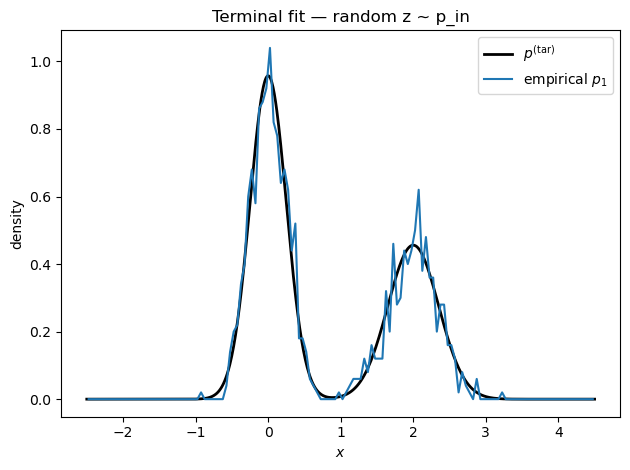

In [18]:
# B: terminal validation
fig_B = terminal_validation(snaps_B, gm_tar, label="random z ~ p_in")
fig_B.savefig(FIG_DIR / "e4_B_terminal.pdf"); plt.show()

### B: sample trajectories (small batch)

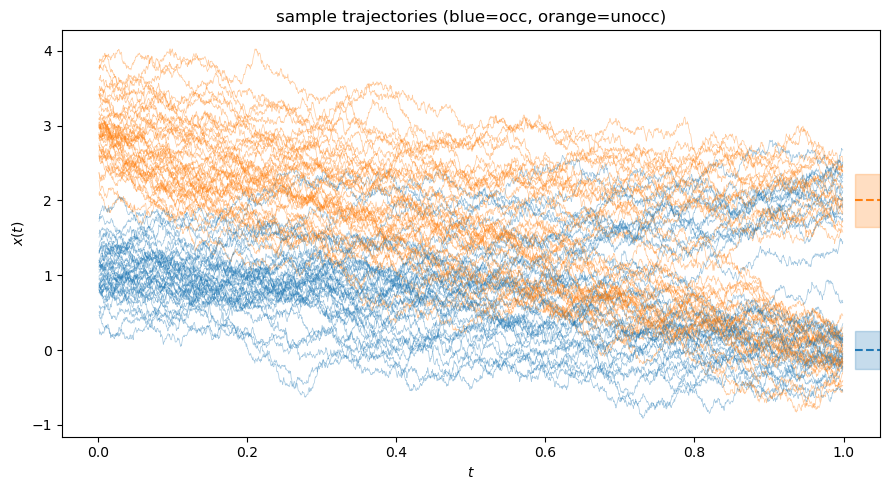

In [19]:
# B: trajectory visualization
B_show = 80
z_show, lab_show = sample_gmm_1d(gm_in, B_show, seed=11)

x_tilde = torch.zeros((B_show, 1), dtype=dtype, device=device)

times = _build_break_aligned_grid(
    n_steps=2000, breaks=sf.coeffs.breaks,
    dtype=dtype, device=device, time_domain=sf.time_domain,
)
bset = _make_break_set(sf.coeffs.breaks, dtype=dtype, device=device,
                       time_domain=sf.time_domain)
dt_vec = times[1:] - times[:-1]

traj = torch.empty((times.numel(), B_show, 1), dtype=dtype, device=device)
traj[0] = x_tilde + z_show   # store in physical coords

gen = torch.Generator(device=device); gen.manual_seed(11)
for i in range(times.numel() - 1):
    t = times[i]
    dt = dt_vec[i]
    t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device, post_jump_eps=1e-12)
    drift = sf.u_star(t_eval, x_tilde, z_show)
    noise = torch.randn((B_show, 1), dtype=dtype, device=device, generator=gen)
    x_tilde = x_tilde + drift * dt + torch.sqrt(dt) * noise
    traj[i+1] = x_tilde + z_show

traj_np = traj.detach().cpu().numpy().squeeze(-1)
times_np = times.detach().cpu().numpy()
lab_np = lab_show.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(9, 5))
colors = {0: "tab:blue", 1: "tab:orange"}
for i in range(B_show):
    ax.plot(times_np, traj_np[:, i], color=colors[lab_np[i]], alpha=0.4, lw=0.5)

# target bands at t=1
for k in range(2):
    mk = float(m_tar[k, 0])
    sk = float(s_tar[k])
    ax.axhspan(mk - sk, mk + sk, xmin=0.97, xmax=1.0, color=colors[k], alpha=0.25)
    ax.axhline(mk, xmin=0.97, xmax=1.0, color=colors[k], ls='--', lw=1.5)

ax.set_xlabel("$t$"); ax.set_ylabel("$x(t)$")
ax.set_title("sample trajectories (blue=occ, orange=unocc)")
fig.tight_layout()
fig.savefig(FIG_DIR / "e4_B_trajectories.pdf"); plt.show()

## Summary

| Test | Method | Terminal match |
|------|--------|---------------|
| A1   | Coordinate-shift (gold standard) | ✓ |
| A2   | Shift propagators (`ShiftedField`) | ✓ (should match A1) |
| B    | Random $z \sim p^{(\mathrm{in})}$ via propagators | ✓ |

The shift propagators $\lambda^+, \lambda^-_x, \lambda^-_y$ are computed
**once** and enable per-particle $z$-corrections at $O(d)$ cost per step,
with no per-$z$ coefficient rebuild.